In [1]:
import os
import numpy as np
import pandas as pd

DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/data'
MODEL_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/model'

In [2]:
problem_df = pd.read_csv(os.path.join(DATA_PATH, 'problem.csv'))
problem_df['problem_id'] = problem_df['problem_id'].astype(str)

course_df = pd.read_csv(os.path.join(DATA_PATH, 'course_detail.csv'))
course_df['problem_num'] = course_df['problem_num'].astype(str)

in_course_problem_num_list = list(set(course_df['problem_num'].unique().tolist()) & set(problem_df['problem_id'].unique().tolist()))

course_df = course_df.set_index('problem_num').loc[in_course_problem_num_list, :].reset_index(drop = False).sort_values('course_id').reset_index(drop = True)

In [3]:
# problem_association_seq 제작

import re

problem_association_seq_list = set()

problem_association_list = problem_df['problem_association'].tolist()
title_list = problem_df['title'].tolist()
for title, problem_association in zip(title_list, problem_association_list):
    problem_association = eval(problem_association)
    if problem_association:
        problem_association += [title]
        problem_association = re.findall(r'([0-9]+?)번', '#'.join(problem_association))
        problem_association_seq_list.add(tuple(problem_association))

problem_association_seq_list = list(map(list, problem_association_seq_list))

len(problem_association_seq_list)

79

In [4]:
# level로 seq 제작

problem_level_seq_list = []

group_df = problem_df.groupby('level')

for level, df in group_df:
    problem_level_seq_list.append(df['problem_id'].tolist())

len(problem_level_seq_list)

31

In [5]:
# tag로 seq 제작

problem_tag_seq_list = []

tag_list = []

def get_preprocessing_tags(tags):
    global tag_list
    tags = eval(tags)
    if tags:
        tags = [tag['key'] for tag in tags]
        tag_list += tags
    return tags

problem_df['preprocessing_tags'] = problem_df['problem_tags'].apply(lambda x : get_preprocessing_tags(x))
tag_list = list(set(tag_list))
problem_num_list = problem_df['problem_id'].tolist()

tag_df = pd.DataFrame(data = np.zeros((len(problem_num_list), len(tag_list))), columns = tag_list, index = problem_num_list)

for df in problem_df.iloc:
    tag_df.loc[df['problem_id'], df['preprocessing_tags']] = 1

for tag in tag_list:
    problem_tag_seq = tag_df[tag_df[tag] == 1].index.tolist()
    problem_tag_seq_list.append(problem_tag_seq)
    
len(problem_tag_seq_list)

186

In [6]:
# 문제집으로 seq 제작
problem_course_seq_list = []

group_df = course_df.groupby('course_id')

for course_id, df in group_df:
    problem_course_seq_list.append(
        df['problem_num'].tolist()
    )

len(problem_course_seq_list)

2399

In [7]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec
import datetime

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.loss_to_be_subed = 0
        self.loss_now = 987654321

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed

        self.loss_to_be_subed = loss

        if loss_now < self.loss_now:
            self.loss_now = loss_now
            model.save(os.path.join(MODEL_PATH, 'Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128.model'))
            print(f'Loss after epoch {self.epoch}: {loss_now}')
            print('Model 저장')
        self.epoch += 1

start = datetime.datetime.now()

sentences = problem_association_seq_list + problem_level_seq_list + problem_tag_seq_list

model = Word2Vec(
                sentences = sentences,
                seed = 22,
                epochs = 300,
                min_count = 1,
                vector_size = 128,
                sg = 0,
                negative = 10,
                window = 987654321,
                compute_loss = True, 
                callbacks=[callback()],
                 )

print("Time passed: " + str(datetime.datetime.now() - start))

Loss after epoch 1: 46784.21875
Model 저장
Loss after epoch 3: 37135.515625
Model 저장
Loss after epoch 4: 36409.40625
Model 저장
Loss after epoch 5: 35535.71875
Model 저장
Loss after epoch 6: 32710.21875
Model 저장
Loss after epoch 7: 29092.96875
Model 저장
Loss after epoch 8: 26731.15625
Model 저장
Loss after epoch 9: 25193.375
Model 저장
Loss after epoch 10: 24253.375
Model 저장
Loss after epoch 11: 23532.90625
Model 저장
Loss after epoch 13: 22536.1875
Model 저장
Loss after epoch 14: 22017.9375
Model 저장
Loss after epoch 15: 21273.875
Model 저장
Loss after epoch 17: 20734.4375
Model 저장
Loss after epoch 18: 20530.4375
Model 저장
Loss after epoch 20: 20168.9375
Model 저장
Loss after epoch 21: 19791.25
Model 저장
Loss after epoch 22: 19650.875
Model 저장
Loss after epoch 23: 19527.625
Model 저장
Loss after epoch 24: 19164.9375
Model 저장
Loss after epoch 25: 19121.125
Model 저장
Loss after epoch 26: 19068.9375
Model 저장
Loss after epoch 28: 18529.0625
Model 저장
Loss after epoch 29: 18449.75
Model 저장
Loss after epoch 30: 1820

In [28]:
from gensim.models import Word2Vec

model = Word2Vec.load(os.path.join(MODEL_PATH, 'Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128.model'))

In [9]:
Problem_list = model.wv.key_to_index.keys()

arr = []

for Problem in Problem_list:
    arr.append(model.wv[Problem])

arr = np.array(arr)

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


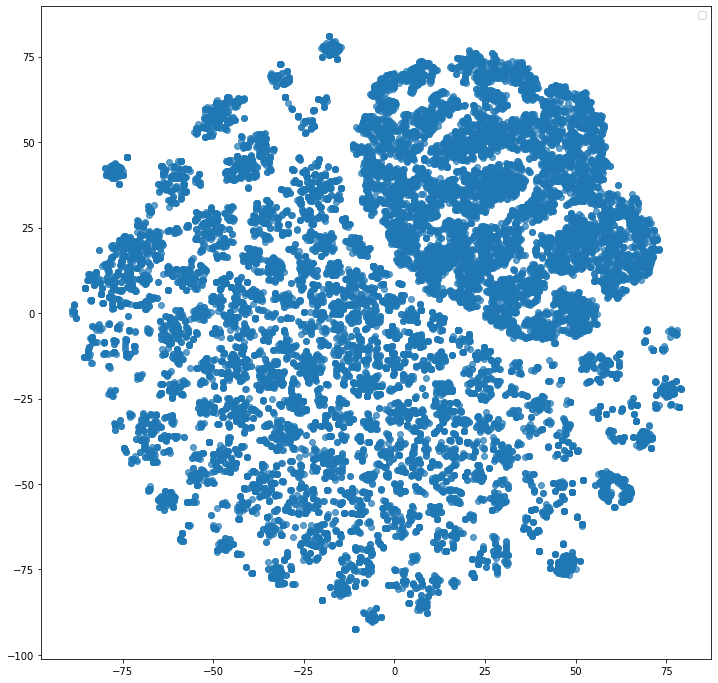

In [11]:
# Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128-model

import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7) 
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


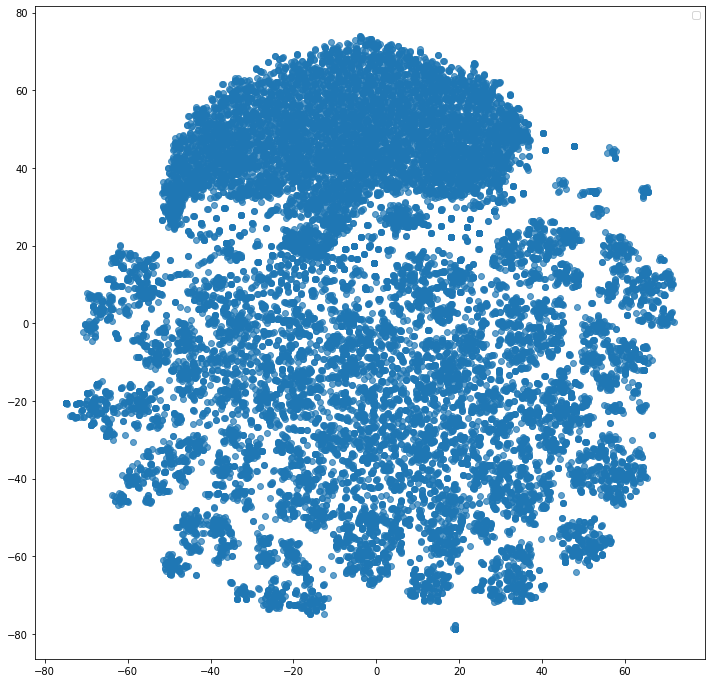

In [11]:
# Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-problem_course_seq-32-model

import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7) 
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


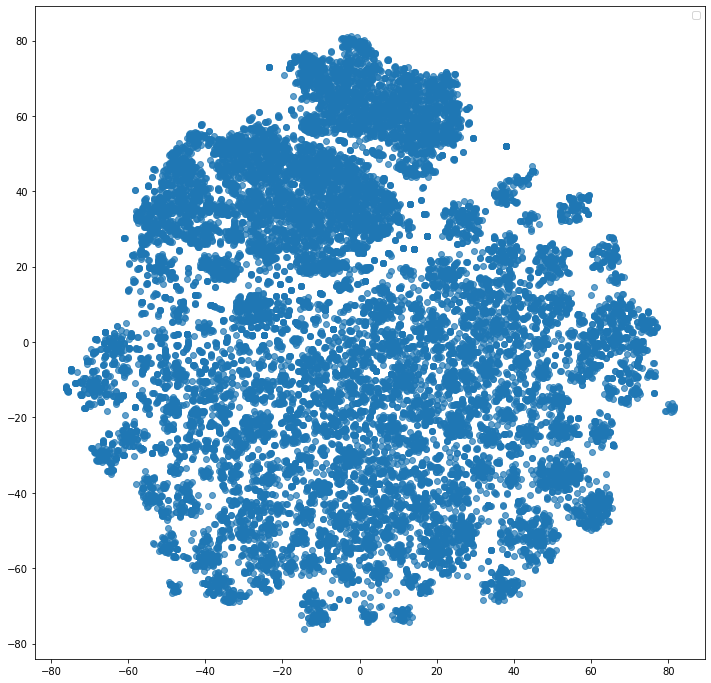

In [16]:
# Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-problem_course_seq-model

import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7) 
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


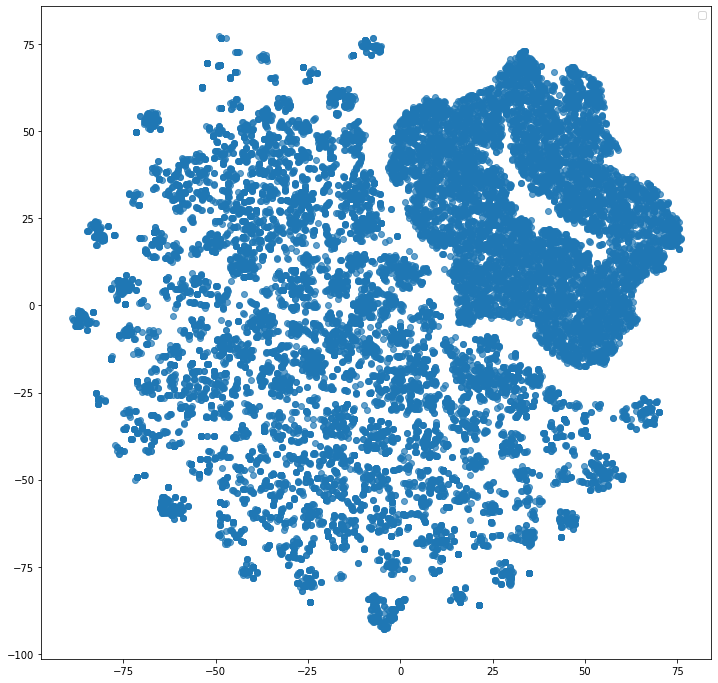

In [37]:
# Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-model

import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7) 
plt.legend()
plt.show()